## Semantic Segmentation

In semantic segmentation, each pixel is classified according to the class of the object it
belongs to (e.g., road, car, pedestrian, building, etc.). Note that different 
objects of the same class are not distinguished. For example, all the bicycles 
on the right side of the segmented image end up as one big lump of pixels. The
main difficulty in this task is that when images go through a regular CNN, they gradually 
lose their spatial resolution (due to the layers with strides greater than 1); so, a
regular CNN may end up knowing that there’s a person somewhere in the bottom left
of the image, but it will not be much more precise than that.

Just like for object detection, there are many different approaches to tackle this prob‐
lem, some quite complex. However, a fairly simple solution was proposed in the 2015
paper by Jonathan Long et al. (Fully Convolutional Networks for Semantic Segmentation).
The authors start by taking a pretrained CNN and turning it into an FCN. 
The CNN applies an overall stride of 32 to the input image (i.e., if you add up all 
the strides greater than 1), meaning the last layer outputs feature maps that are 32 times
smaller than the input image. This is clearly too coarse, so they add a single upsampling layer
that multiplies the resolution by 32.

<img src='images/semantic_segmentation.png'>

There are several solutions available for upsampling such as bilinear interpolation, but that only works
reasonably well up to x4 or x8. Instead, they use a *transposed convolutional layer* (sometimes reffered
to as a *deconvolutional layer*, but that should be avoided). It is equivalent to first stretching the image
by inserting empty rows and columns (full of zeros), then performing a regular convolution. The transposed
convolutional layer can be initalized to perfrom something close to linear interpolation, but since it is a 
trainable layer, it will learn to do better during training. In `tf.keras`, you can use the `Conv2DTranspose` layer.

<img src='images/upsampling_transposedConv.png'>

This solution is OK, but still to imprecise. To do beter, the authors aded skip connections from lower layers:
for example, they upsampled the output image by a factor of 2 (instead 32), and they added the output of a lower
layer that had this double resolution. Then they upsampled the result by a fator of 16, leading to a total upsampling factor of 32. This recovered some of the spatial resolution that was lost in earlier pooling layers.
In their best architecture, they used a second similar skip connection to recover even finer details from an even lower layer. In short, the output of the original CNN goes through the following extra steps: upscale
×2, add the output of a lower layer (of the appropriate scale), upscale ×2, add the output of an even lower
layer, and finally upscale ×8. It is even possible to scale up beyond the size of the original image: this can be used to increase the resolution of an image, which is a technique called *super-resolution*.

<img src='images/skip_layers_recovery.png'>

In [ ]:
import keras
import tensorflow as tf
import numpy as np

In [ ]:
# Oxford-IIIT Pets dataset

import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete5FJKQ6/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete5FJKQ6/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [ ]:
import matplotlib.pyplot as plt

def display(display_list):
    plt.figure(figsize=(8, 8))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
# Map the preprocessing load_image function to dataset

train = dataset['train'].map(load_image_train,  num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
# Batch the dataset

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)

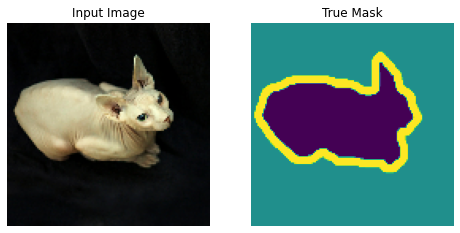

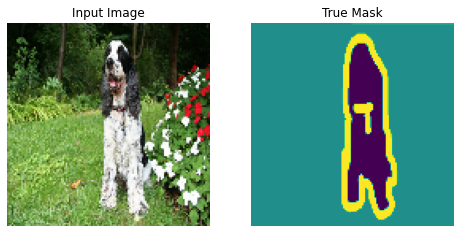

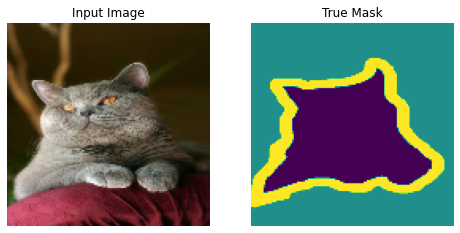

In [ ]:
for sample_image, sample_mask in train.take(3):
    display([sample_image, sample_mask])

## Building the model

Building a fully convolutional network based on a VGG-16 classification network pretrained on a ImageNet.

In [ ]:
# Some standard deep CNN networks that have made significant contributions to the field of computer vision
# are often used as the basis of semantic segmentation systems:

# Let's begin by convolutionalizing proven classification architectures.
# We pick the VGG 16-layer net, trained on ImageNet dataset, and discard the final classification layers
# (three dense layers).

base_model = keras.applications.VGG16(input_shape=[128, 128, 3], weights='imagenet', include_top=False)

In [ ]:
# To build a decoder portion of FCN-8, we will have to upsample the input to the original image size.
# The shape of the tensor after the final convolutional transpose layer should be 4-dimensional:
# (batch_size, IMG_height, IMG_width, num_classes).

from keras import layers

n_classes = 21

# 1x1 convolution instead of a VGG dense output layers
conv_1x1 = layers.Conv2D(filters=n_classes, kernel_size=1)(base_model.output)

# Upsampling x2, output size = 8x8
up_conv1 = layers.Conv2DTranspose(filters=n_classes, kernel_size=4,
                                  strides=2, padding='same', activation='relu') (conv_1x1)

# Adding a skip connection
vgg_block5 = base_model.get_layer('block5_conv3').output
skip_layer1 = layers.Conv2D(filters=n_classes, kernel_size=1)(vgg_block5)
skip_conn1 = tf.add(up_conv1, skip_layer1)

# Upsampling x2, output size = 16x16
up_conv2 = layers.Conv2DTranspose(filters=n_classes, kernel_size=4,
                                  strides=2, padding='same', activation='relu')(skip_conn1)

# Adding a skip connection
vgg_block4 = base_model.get_layer('block4_conv3').output
skip_layer2 = layers.Conv2D(filters=n_classes, kernel_size=1)(vgg_block4)
skip_conn2 = tf.add(up_conv2, skip_layer2)

# Upsamling x2, output size = 32x32
up_conv3 = layers.Conv2DTranspose(filters=n_classes, kernel_size=4,
                                  strides=2, padding='same', activation='relu')(skip_conn2)

# Adding a skip connection
vgg_block3 = base_model.get_layer('block3_conv3').output
skip_layer3 = layers.Conv2D(filters=n_classes, kernel_size=1)(vgg_block3)
skip_conn3 = tf.add(up_conv3, skip_layer3)

# Upsampling x4, output size = 128x128
up_conv4 = layers.Conv2DTranspose(filters=n_classes, kernel_size=8,
                                  strides=4, padding='same')(skip_conn3)

model = keras.models.Model(inputs=base_model.input, outputs=up_conv4)

In [ ]:
model.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
______________________________________________________________________________________

### Training the model

The loss being used here is `losses.SparseCategoricalCrossentropy(from_logits=True)`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and `SparseCategoricalCrossentropy(from_logits=True)` is the recommended loss for such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value.

In [ ]:
# Freezing the layers of the base model
base_model.trainable = False

# Compiling
model.compile(optimizer='Adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, 
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

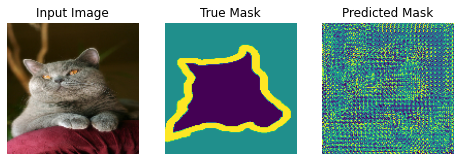

In [ ]:
show_predictions()

In [ ]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=8)

In [ ]:
def plot_results(history):
  plt.plot(history.history['loss'], '-o', color='orange', label='loss')
  plt.plot(history.history['val_loss'], '-o', label='val_loss')
  plt.legend()
  plt.show()

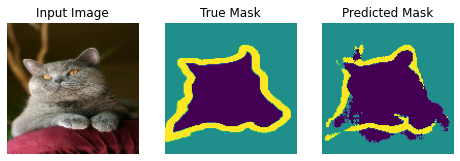


Sample Prediction after epoch 10

58/58 [==============================] - 8s 138ms/step - loss: 0.3451 - val_loss: 0.3630


In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

history = model.fit(train_dataset, epochs=EPOCHS,
                    validation_steps=VALIDATION_STEPS,
                    validation_data = test_dataset,
                    callbacks=[DisplayCallback()])


train_loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

In [ ]:
# Unfreezing the base model layers
base_model.trainable = True

# Compiling and adjusting the learning rate (smaller this time)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

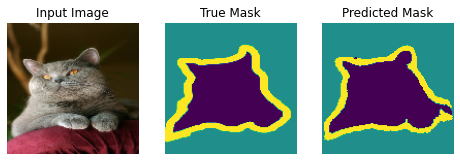


Sample Prediction after epoch 10

58/58 [==============================] - 19s 321ms/step - loss: 0.1757 - val_loss: 0.2715


In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

history = model.fit(train_dataset, epochs=EPOCHS,
                    validation_steps=VALIDATION_STEPS,
                    validation_data = test_dataset,
                    callbacks=[DisplayCallback(), reduce_lr, early_stopping])

train_loss_history += history.history['loss']
val_loss_history += history.history['val_loss']

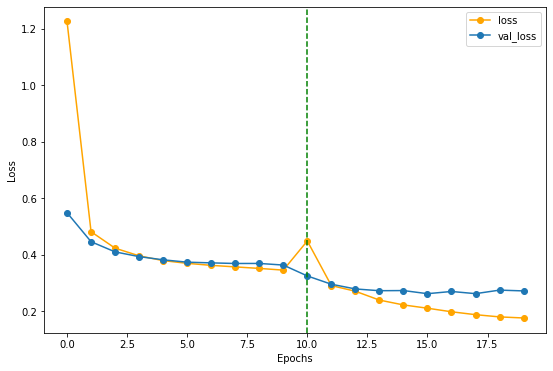

In [ ]:
# Plotting the results
plt.figure(figsize=(9,6))
plt.plot(train_loss_history, '-o', color='orange', label='loss')
plt.plot(val_loss_history, '-o', label='val_loss')
plt.axvline(x=10, color='green' ,linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Firstly, we trained only the upper layers of network (decoder part) for 10 epochs and then
# unfroze the base model layers and set a smaller learning rate so that we don't mess the pretrained
# weights too much.
# After unfreezing the layers and setting a new learning rate, the model had to be recompiled and
# we can see that learning suffers a bit after this until Adam adjusts the learning rate, the momentums, etc.

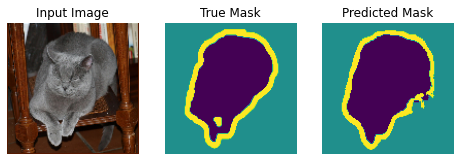

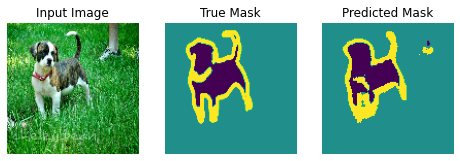

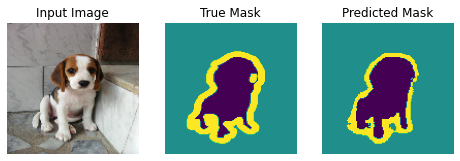

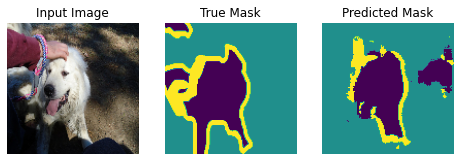

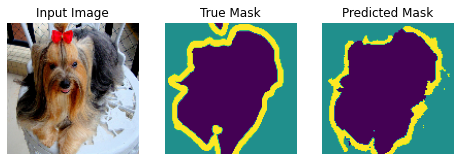

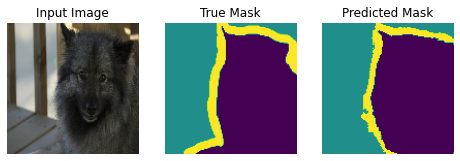

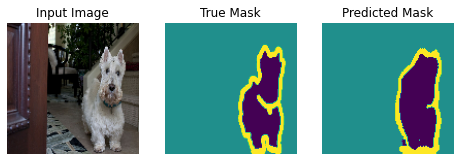

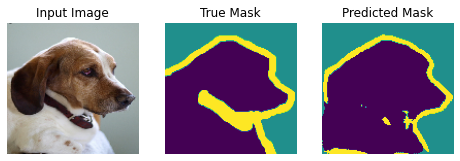

In [ ]:
show_predictions(dataset=test_dataset.shuffle(100), num=4)